https://docs.google.com/document/d/103yulQ3ILCKRoh4ws1oCnSoT54MJQuDS8-nth6l_6GY/edit

### Face mask detecion

Mateusz Hryciów

Kacper Zagórski

Mateusz Szewczyk

In [170]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time

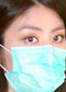

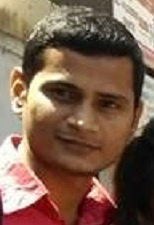

In [171]:
from PIL import Image
display(Image.open('./dataset/with_mask/0_0_0 copy 10.jpg'))
display(Image.open('./dataset/without_mask/1.jpg'))

In [172]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#needed in order to display images after they are transformed
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [173]:
train_data = datasets.ImageFolder('./dataset',transform=train_transform)
test_data = datasets.ImageFolder('./dataset',transform=test_transform)
class_names = train_data.classes

In [174]:
np.random.seed(10)

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))
np.random.shuffle(indices)
train_idx, test_idx = indices[split:], indices[:split]

#balanced sampling (against the classes) + taking only the train indexes
train_sampler = SubsetRandomSampler(train_idx) 
test_sampler = SubsetRandomSampler(test_idx)

In [175]:
print(len(train_idx))
len(test_idx)

3094


773

In [178]:
batch_size = 100 #only to display images, trained with batch = 100
workers = 0

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=workers)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, sampler=test_sampler, num_workers=workers)

Class: ['with_mask', 'without_mask', 'without_mask', 'without_mask', 'with_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'with_mask']


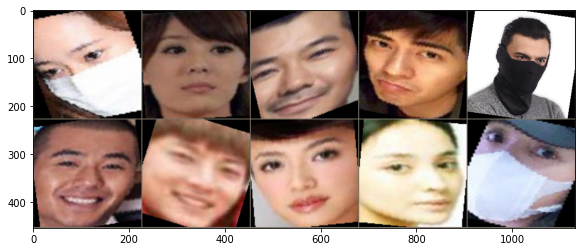

In [177]:
for images,labels in train_loader: 
    break

print('Class:', [class_names[i] for i in labels])

im = make_grid(images, nrow=5)
# denormalizacja obrazow, żeby widok był przyjemny dla oka
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
# imshow wymaga podania wymiarów w innej kolejności
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [179]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        #(in_chan, out_chan, size, stride, padding)
        self.conv1 = nn.Conv2d(3, 16, 10, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 20, 3, 1)
        # parameter - dropout probability
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9*9*32, 200)
        self.fc2 = nn.Linear(200, 80)
        self.fc3 = nn.Linear(80, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X)) #rectified linear unit - activation function
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.dropout1(X)
        X = X.view(-1, 9*9*32) 
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1) # converting logits to odds

In [180]:
CNNmodel = ConvolutionalNetwork()

In [181]:
CNNmodel.parameters

<bound method Module.parameters of ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(10, 10), stride=(3, 3), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(20, 20), stride=(3, 3), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2592, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=2, bias=True)
)>

In [182]:
def train_model(CNNmodel, criterion, optimizer, epochs):
    start_time = time.time()

    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []

    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0

        for b,(X_train,y_train) in enumerate(train_loader):

            b+=1

            # prediction
            y_pred = CNNmodel(X_train)
            # loss
            loss = criterion(y_pred, y_train)
            
            # predicted class
            predicted = torch.max(y_pred,1)[1]
            # number of correct predictions in batch (sumnming all 1's)
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr

            # zerowanie gradientu
            optimizer.zero_grad()
            # propagacja wsteczna
            loss.backward()
            # uaktualnienie parametrów
            optimizer.step()
            
#             if b%10 == 0:
            print(f'Epoka: {i}, seria: {b}, strata: {loss}, dokładność: {trn_corr.item()/b:7.3f}%')

        train_losses.append(loss)
        train_correct.append(trn_corr)

        # testowanie po każdej iteracji
        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(test_loader):

                y_val = CNNmodel(X_test)

                predicted = torch.max(y_val,1)[1]
                tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)

    total_time = (time.time() - start_time)/60
    
    print(f'Czas uczenia: {total_time} minut.')
    
    return CNNmodel, train_losses, test_losses, train_correct, test_correct

### Learning rate: 0.01, epoch no.: 10

In [188]:
criterion = nn.CrossEntropyLoss()
CNNmodel = ConvolutionalNetwork()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.01)

In [189]:
result = train_model(CNNmodel, criterion, optimizer, 10)

CNNmodel,train_losses, test_losses, train_correct, test_correct = result

Epoka: 0, seria: 1, strata: 0.6922532916069031, dokładność:  53.000%
Epoka: 0, seria: 2, strata: 277.4242248535156, dokładność:  54.000%
Epoka: 0, seria: 3, strata: 4.209969997406006, dokładność:  52.000%
Epoka: 0, seria: 4, strata: 3.0837578773498535, dokładność:  52.000%
Epoka: 0, seria: 5, strata: 6.440881252288818, dokładność:  54.000%
Epoka: 0, seria: 6, strata: 0.7005720734596252, dokładność:  53.500%
Epoka: 0, seria: 7, strata: 0.7148649096488953, dokładność:  52.571%
Epoka: 0, seria: 8, strata: 0.6776489019393921, dokładność:  53.500%
Epoka: 0, seria: 9, strata: 1.0324965715408325, dokładność:  54.889%
Epoka: 0, seria: 10, strata: 0.668744683265686, dokładność:  55.200%
Epoka: 0, seria: 11, strata: 0.6903313994407654, dokładność:  55.273%
Epoka: 0, seria: 12, strata: 0.694288969039917, dokładność:  54.750%
Epoka: 0, seria: 13, strata: 0.6937982439994812, dokładność:  54.385%
Epoka: 0, seria: 14, strata: 0.689971923828125, dokładność:  54.429%
Epoka: 0, seria: 15, strata: 0.6958

Epoka: 3, seria: 26, strata: 0.6955501437187195, dokładność:  50.115%
Epoka: 3, seria: 27, strata: 0.696349561214447, dokładność:  49.852%
Epoka: 3, seria: 28, strata: 0.6937316656112671, dokładność:  49.821%
Epoka: 3, seria: 29, strata: 0.6950907111167908, dokładność:  49.655%
Epoka: 3, seria: 30, strata: 0.694815993309021, dokładność:  49.500%
Epoka: 3, seria: 31, strata: 0.6948264241218567, dokładność:  49.226%
Epoka: 4, seria: 1, strata: 0.6930090188980103, dokładność:  51.000%
Epoka: 4, seria: 2, strata: 0.6941949725151062, dokładność:  46.000%
Epoka: 4, seria: 3, strata: 0.6932787299156189, dokładność:  46.000%
Epoka: 4, seria: 4, strata: 0.6930997967720032, dokładność:  47.250%
Epoka: 4, seria: 5, strata: 0.6926601529121399, dokładność:  48.600%
Epoka: 4, seria: 6, strata: 0.6931996941566467, dokładność:  48.833%
Epoka: 4, seria: 7, strata: 0.694344699382782, dokładność:  48.429%
Epoka: 4, seria: 8, strata: 0.6981648802757263, dokładność:  46.750%
Epoka: 4, seria: 9, strata: 0.6

Epoka: 7, seria: 20, strata: 0.6929938793182373, dokładność:  47.900%
Epoka: 7, seria: 21, strata: 0.6933456659317017, dokładność:  47.714%
Epoka: 7, seria: 22, strata: 0.6931788921356201, dokładność:  47.636%
Epoka: 7, seria: 23, strata: 0.6930108070373535, dokładność:  47.957%
Epoka: 7, seria: 24, strata: 0.6929280161857605, dokładność:  48.167%
Epoka: 7, seria: 25, strata: 0.6927854418754578, dokładność:  48.360%
Epoka: 7, seria: 26, strata: 0.693005383014679, dokładność:  48.462%
Epoka: 7, seria: 27, strata: 0.6936879754066467, dokładność:  48.444%
Epoka: 7, seria: 28, strata: 0.6946116089820862, dokładność:  48.321%
Epoka: 7, seria: 29, strata: 0.6944139003753662, dokładność:  48.241%
Epoka: 7, seria: 30, strata: 0.6926732659339905, dokładność:  48.367%
Epoka: 7, seria: 31, strata: 0.6923197507858276, dokładność:  48.419%
Epoka: 8, seria: 1, strata: 0.6920463442802429, dokładność:  54.000%
Epoka: 8, seria: 2, strata: 0.6939278244972229, dokładność:  51.000%
Epoka: 8, seria: 3, str

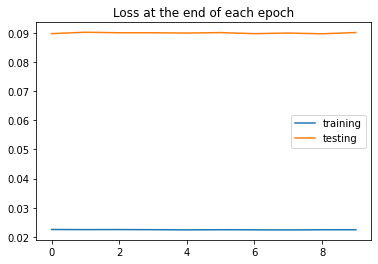

In [190]:
plt.plot([x/(len(train_idx)/100) for x in np.array(train_losses)], label='training')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_losses)], label='testing')
plt.title('Loss at the end of each epoch')
plt.legend()

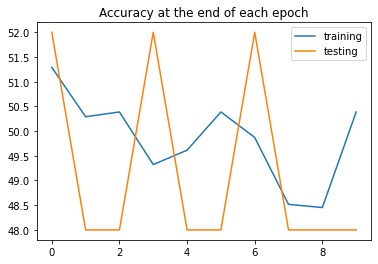

In [191]:
plt.plot([x/(len(train_idx)/100) for x in np.array(train_correct)], label='training')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_correct)], label='testing')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [192]:
torch.save(CNNmodel.state_dict(), 'siec_od_lr_01_ep10.pt')

### Learning rate: 0.0001, epoch no.: 40

In [193]:
criterion = nn.CrossEntropyLoss()
CNNmodel = ConvolutionalNetwork()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.0001)

In [194]:
result = train_model(CNNmodel, criterion, optimizer, 40)

CNNmodel,train_losses, test_losses, train_correct, test_correct = result

Epoka: 0, seria: 1, strata: 0.6957274675369263, dokładność:  48.000%
Epoka: 0, seria: 2, strata: 0.6880462169647217, dokładność:  51.500%
Epoka: 0, seria: 3, strata: 0.6867082715034485, dokładność:  50.667%
Epoka: 0, seria: 4, strata: 0.677925169467926, dokładność:  52.250%
Epoka: 0, seria: 5, strata: 0.672107458114624, dokładność:  52.400%
Epoka: 0, seria: 6, strata: 0.6814550161361694, dokładność:  50.833%
Epoka: 0, seria: 7, strata: 0.6406927704811096, dokładność:  53.571%
Epoka: 0, seria: 8, strata: 0.6458320617675781, dokładność:  54.750%
Epoka: 0, seria: 9, strata: 0.6663621664047241, dokładność:  55.222%
Epoka: 0, seria: 10, strata: 0.6055683493614197, dokładność:  56.900%
Epoka: 0, seria: 11, strata: 0.578340470790863, dokładność:  59.273%
Epoka: 0, seria: 12, strata: 0.5324411988258362, dokładność:  61.667%
Epoka: 0, seria: 13, strata: 0.5230998992919922, dokładność:  63.538%
Epoka: 0, seria: 14, strata: 0.4830218553543091, dokładność:  65.214%
Epoka: 0, seria: 15, strata: 0.4

Epoka: 3, seria: 25, strata: 0.18588761985301971, dokładność:  91.640%
Epoka: 3, seria: 26, strata: 0.22861915826797485, dokładność:  91.692%
Epoka: 3, seria: 27, strata: 0.23523949086666107, dokładność:  91.630%
Epoka: 3, seria: 28, strata: 0.22432073950767517, dokładność:  91.643%
Epoka: 3, seria: 29, strata: 0.16149763762950897, dokładność:  91.724%
Epoka: 3, seria: 30, strata: 0.14806592464447021, dokładność:  91.833%
Epoka: 3, seria: 31, strata: 0.19037730991840363, dokładność:  91.677%
Epoka: 4, seria: 1, strata: 0.36602166295051575, dokładność:  86.000%
Epoka: 4, seria: 2, strata: 0.19267070293426514, dokładność:  89.000%
Epoka: 4, seria: 3, strata: 0.16025173664093018, dokładność:  90.667%
Epoka: 4, seria: 4, strata: 0.2281041294336319, dokładność:  90.750%
Epoka: 4, seria: 5, strata: 0.16412368416786194, dokładność:  91.600%
Epoka: 4, seria: 6, strata: 0.25795120000839233, dokładność:  91.333%
Epoka: 4, seria: 7, strata: 0.2316179722547531, dokładność:  91.857%
Epoka: 4, seria

Epoka: 7, seria: 18, strata: 0.19370223581790924, dokładność:  92.556%
Epoka: 7, seria: 19, strata: 0.14530597627162933, dokładność:  92.737%
Epoka: 7, seria: 20, strata: 0.1147116869688034, dokładność:  92.950%
Epoka: 7, seria: 21, strata: 0.2591422200202942, dokładność:  92.857%
Epoka: 7, seria: 22, strata: 0.11353150010108948, dokładność:  93.045%
Epoka: 7, seria: 23, strata: 0.1785057783126831, dokładność:  93.043%
Epoka: 7, seria: 24, strata: 0.21871060132980347, dokładność:  93.083%
Epoka: 7, seria: 25, strata: 0.2284756302833557, dokładność:  93.040%
Epoka: 7, seria: 26, strata: 0.20148475468158722, dokładność:  93.077%
Epoka: 7, seria: 27, strata: 0.14507220685482025, dokładność:  93.148%
Epoka: 7, seria: 28, strata: 0.17030039429664612, dokładność:  93.107%
Epoka: 7, seria: 29, strata: 0.18010732531547546, dokładność:  93.069%
Epoka: 7, seria: 30, strata: 0.18430973589420319, dokładność:  93.100%
Epoka: 7, seria: 31, strata: 0.13351914286613464, dokładność:  92.935%
Epoka: 8, 

Epoka: 11, seria: 10, strata: 0.11098666489124298, dokładność:  94.100%
Epoka: 11, seria: 11, strata: 0.22035498917102814, dokładność:  94.182%
Epoka: 11, seria: 12, strata: 0.11315008997917175, dokładność:  94.417%
Epoka: 11, seria: 13, strata: 0.12937162816524506, dokładność:  94.462%
Epoka: 11, seria: 14, strata: 0.09483231604099274, dokładność:  94.714%
Epoka: 11, seria: 15, strata: 0.1708260178565979, dokładność:  94.533%
Epoka: 11, seria: 16, strata: 0.11609597504138947, dokładność:  94.625%
Epoka: 11, seria: 17, strata: 0.08995828777551651, dokładność:  94.824%
Epoka: 11, seria: 18, strata: 0.16088451445102692, dokładność:  94.667%
Epoka: 11, seria: 19, strata: 0.13916024565696716, dokładność:  94.684%
Epoka: 11, seria: 20, strata: 0.14259850978851318, dokładność:  94.650%
Epoka: 11, seria: 21, strata: 0.1427212655544281, dokładność:  94.714%
Epoka: 11, seria: 22, strata: 0.19336898624897003, dokładność:  94.591%
Epoka: 11, seria: 23, strata: 0.22224049270153046, dokładność:  94

Epoka: 15, seria: 1, strata: 0.0730007141828537, dokładność:  98.000%
Epoka: 15, seria: 2, strata: 0.09415115416049957, dokładność:  98.000%
Epoka: 15, seria: 3, strata: 0.24332252144813538, dokładność:  95.667%
Epoka: 15, seria: 4, strata: 0.15597617626190186, dokładność:  95.250%
Epoka: 15, seria: 5, strata: 0.17702716588974, dokładność:  95.400%
Epoka: 15, seria: 6, strata: 0.1505812406539917, dokładność:  95.500%
Epoka: 15, seria: 7, strata: 0.08948817104101181, dokładność:  95.714%
Epoka: 15, seria: 8, strata: 0.07393950968980789, dokładność:  95.875%
Epoka: 15, seria: 9, strata: 0.14883117377758026, dokładność:  95.556%
Epoka: 15, seria: 10, strata: 0.1349344700574875, dokładność:  95.400%
Epoka: 15, seria: 11, strata: 0.04721087962388992, dokładność:  95.636%
Epoka: 15, seria: 12, strata: 0.11438503861427307, dokładność:  95.667%
Epoka: 15, seria: 13, strata: 0.22615407407283783, dokładność:  95.231%
Epoka: 15, seria: 14, strata: 0.10174579918384552, dokładność:  95.286%
Epoka: 

Epoka: 18, seria: 23, strata: 0.15620256960391998, dokładność:  95.652%
Epoka: 18, seria: 24, strata: 0.13155914843082428, dokładność:  95.542%
Epoka: 18, seria: 25, strata: 0.1522482931613922, dokładność:  95.400%
Epoka: 18, seria: 26, strata: 0.16479435563087463, dokładność:  95.346%
Epoka: 18, seria: 27, strata: 0.13050523400306702, dokładność:  95.259%
Epoka: 18, seria: 28, strata: 0.08222337067127228, dokładność:  95.250%
Epoka: 18, seria: 29, strata: 0.09491321444511414, dokładność:  95.276%
Epoka: 18, seria: 30, strata: 0.10776454210281372, dokładność:  95.300%
Epoka: 18, seria: 31, strata: 0.20867353677749634, dokładność:  95.000%
Epoka: 19, seria: 1, strata: 0.15208812057971954, dokładność:  94.000%
Epoka: 19, seria: 2, strata: 0.08238772302865982, dokładność:  95.500%
Epoka: 19, seria: 3, strata: 0.08255185186862946, dokładność:  96.000%
Epoka: 19, seria: 4, strata: 0.19315582513809204, dokładność:  95.250%
Epoka: 19, seria: 5, strata: 0.13262209296226501, dokładność:  94.800

Epoka: 22, seria: 14, strata: 0.05423794686794281, dokładność:  97.071%
Epoka: 22, seria: 15, strata: 0.08881603926420212, dokładność:  97.067%
Epoka: 22, seria: 16, strata: 0.08966531604528427, dokładność:  96.938%
Epoka: 22, seria: 17, strata: 0.08498947322368622, dokładność:  96.882%
Epoka: 22, seria: 18, strata: 0.11363966763019562, dokładność:  96.833%
Epoka: 22, seria: 19, strata: 0.09746616333723068, dokładność:  96.842%
Epoka: 22, seria: 20, strata: 0.18262363970279694, dokładność:  96.800%
Epoka: 22, seria: 21, strata: 0.13266605138778687, dokładność:  96.571%
Epoka: 22, seria: 22, strata: 0.07942667603492737, dokładność:  96.636%
Epoka: 22, seria: 23, strata: 0.1964484453201294, dokładność:  96.522%
Epoka: 22, seria: 24, strata: 0.11707846820354462, dokładność:  96.458%
Epoka: 22, seria: 25, strata: 0.0486060194671154, dokładność:  96.560%
Epoka: 22, seria: 26, strata: 0.07725159823894501, dokładność:  96.577%
Epoka: 22, seria: 27, strata: 0.15706034004688263, dokładność:  96

Epoka: 26, seria: 5, strata: 0.12779337167739868, dokładność:  97.400%
Epoka: 26, seria: 6, strata: 0.08965242654085159, dokładność:  97.333%
Epoka: 26, seria: 7, strata: 0.14527712762355804, dokładność:  97.143%
Epoka: 26, seria: 8, strata: 0.09634876996278763, dokładność:  97.000%
Epoka: 26, seria: 9, strata: 0.055213991552591324, dokładność:  97.111%
Epoka: 26, seria: 10, strata: 0.04538968577980995, dokładność:  97.400%
Epoka: 26, seria: 11, strata: 0.060942210257053375, dokładność:  97.455%
Epoka: 26, seria: 12, strata: 0.14542162418365479, dokładność:  97.167%
Epoka: 26, seria: 13, strata: 0.050016455352306366, dokładność:  97.231%
Epoka: 26, seria: 14, strata: 0.16064700484275818, dokładność:  96.929%
Epoka: 26, seria: 15, strata: 0.07879455387592316, dokładność:  96.733%
Epoka: 26, seria: 16, strata: 0.07471592724323273, dokładność:  96.688%
Epoka: 26, seria: 17, strata: 0.07799939811229706, dokładność:  96.647%
Epoka: 26, seria: 18, strata: 0.06737963110208511, dokładność:  96

Epoka: 29, seria: 27, strata: 0.11799683421850204, dokładność:  97.222%
Epoka: 29, seria: 28, strata: 0.07484009861946106, dokładność:  97.214%
Epoka: 29, seria: 29, strata: 0.09836751222610474, dokładność:  97.172%
Epoka: 29, seria: 30, strata: 0.10163361579179764, dokładność:  97.100%
Epoka: 29, seria: 31, strata: 0.09146981686353683, dokładność:  96.903%
Epoka: 30, seria: 1, strata: 0.1026412770152092, dokładność:  98.000%
Epoka: 30, seria: 2, strata: 0.13082914054393768, dokładność:  97.000%
Epoka: 30, seria: 3, strata: 0.03147617354989052, dokładność:  97.667%
Epoka: 30, seria: 4, strata: 0.13291147351264954, dokładność:  97.250%
Epoka: 30, seria: 5, strata: 0.11965541541576385, dokładność:  96.800%
Epoka: 30, seria: 6, strata: 0.06063316762447357, dokładność:  96.667%
Epoka: 30, seria: 7, strata: 0.055820632725954056, dokładność:  97.000%
Epoka: 30, seria: 8, strata: 0.05758769437670708, dokładność:  97.000%
Epoka: 30, seria: 9, strata: 0.061416421085596085, dokładność:  97.111%


Epoka: 33, seria: 18, strata: 0.07644261419773102, dokładność:  97.333%
Epoka: 33, seria: 19, strata: 0.04565417394042015, dokładność:  97.368%
Epoka: 33, seria: 20, strata: 0.05964917317032814, dokładność:  97.400%
Epoka: 33, seria: 21, strata: 0.06670576333999634, dokładność:  97.429%
Epoka: 33, seria: 22, strata: 0.013248234055936337, dokładność:  97.545%
Epoka: 33, seria: 23, strata: 0.10067547857761383, dokładność:  97.565%
Epoka: 33, seria: 24, strata: 0.019893664866685867, dokładność:  97.667%
Epoka: 33, seria: 25, strata: 0.07716753333806992, dokładność:  97.680%
Epoka: 33, seria: 26, strata: 0.040776826441287994, dokładność:  97.731%
Epoka: 33, seria: 27, strata: 0.048859406262636185, dokładność:  97.741%
Epoka: 33, seria: 28, strata: 0.12378235906362534, dokładność:  97.714%
Epoka: 33, seria: 29, strata: 0.07795023173093796, dokładność:  97.586%
Epoka: 33, seria: 30, strata: 0.02255207486450672, dokładność:  97.667%
Epoka: 33, seria: 31, strata: 0.08510176837444305, dokładnoś

Epoka: 37, seria: 8, strata: 0.07629509270191193, dokładność:  98.000%
Epoka: 37, seria: 9, strata: 0.05601128935813904, dokładność:  97.889%
Epoka: 37, seria: 10, strata: 0.035482048988342285, dokładność:  98.000%
Epoka: 37, seria: 11, strata: 0.06340661644935608, dokładność:  97.909%
Epoka: 37, seria: 12, strata: 0.03355378285050392, dokładność:  97.917%
Epoka: 37, seria: 13, strata: 0.06457687169313431, dokładność:  98.000%
Epoka: 37, seria: 14, strata: 0.08681214600801468, dokładność:  97.929%
Epoka: 37, seria: 15, strata: 0.038200415670871735, dokładność:  97.933%
Epoka: 37, seria: 16, strata: 0.05816002935171127, dokładność:  97.875%
Epoka: 37, seria: 17, strata: 0.012506303377449512, dokładność:  98.000%
Epoka: 37, seria: 18, strata: 0.04799600690603256, dokładność:  97.944%
Epoka: 37, seria: 19, strata: 0.027180099859833717, dokładność:  98.053%
Epoka: 37, seria: 20, strata: 0.08471720665693283, dokładność:  98.050%
Epoka: 37, seria: 21, strata: 0.06804069876670837, dokładność:

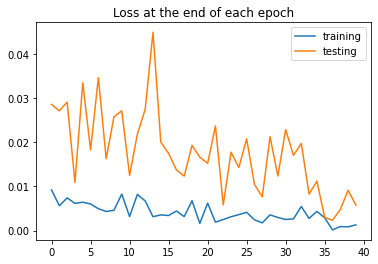

In [195]:
plt.plot([x/(len(train_idx)/100) for x in np.array(train_losses)], label='training')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_losses)], label='testing')
plt.title('Loss at the end of each epoch')
plt.legend()

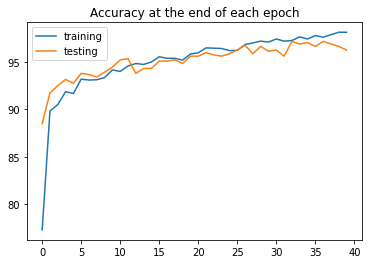

In [196]:
plt.plot([x/(len(train_idx)/100) for x in np.array(train_correct)], label='training')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_correct)], label='testing')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [197]:
torch.save(CNNmodel.state_dict(), 'siec_od_0_lr_0001_ep40.pt')

### Learning rate: 0.00001, epoch no.: 40

In [198]:
criterion = nn.CrossEntropyLoss()
CNNmodel = ConvolutionalNetwork()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.00001)

In [199]:
result = train_model(CNNmodel, criterion, optimizer, 40)

CNNmodel,train_losses, test_losses, train_correct, test_correct = result

Epoka: 0, seria: 1, strata: 0.6947305798530579, dokładność:  49.000%
Epoka: 0, seria: 2, strata: 0.6926353573799133, dokładność:  50.500%
Epoka: 0, seria: 3, strata: 0.6997900605201721, dokładność:  48.667%
Epoka: 0, seria: 4, strata: 0.6921760439872742, dokładność:  49.000%
Epoka: 0, seria: 5, strata: 0.6967824697494507, dokładność:  48.800%
Epoka: 0, seria: 6, strata: 0.692624568939209, dokładność:  49.167%
Epoka: 0, seria: 7, strata: 0.6947309970855713, dokładność:  49.000%
Epoka: 0, seria: 8, strata: 0.6936336755752563, dokładność:  49.125%
Epoka: 0, seria: 9, strata: 0.6966145038604736, dokładność:  48.556%
Epoka: 0, seria: 10, strata: 0.6907845139503479, dokładność:  48.600%
Epoka: 0, seria: 11, strata: 0.6912758350372314, dokładność:  48.818%
Epoka: 0, seria: 12, strata: 0.6876978278160095, dokładność:  49.417%
Epoka: 0, seria: 13, strata: 0.6808919310569763, dokładność:  49.923%
Epoka: 0, seria: 14, strata: 0.6848920583724976, dokładność:  50.143%
Epoka: 0, seria: 15, strata: 0

Epoka: 3, seria: 26, strata: 0.42568331956863403, dokładność:  86.154%
Epoka: 3, seria: 27, strata: 0.40167349576950073, dokładność:  86.185%
Epoka: 3, seria: 28, strata: 0.40484023094177246, dokładność:  86.214%
Epoka: 3, seria: 29, strata: 0.3783373236656189, dokładność:  86.241%
Epoka: 3, seria: 30, strata: 0.4190804958343506, dokładność:  86.133%
Epoka: 3, seria: 31, strata: 0.3715416491031647, dokładność:  85.968%
Epoka: 4, seria: 1, strata: 0.38604477047920227, dokładność:  82.000%
Epoka: 4, seria: 2, strata: 0.3760402798652649, dokładność:  85.000%
Epoka: 4, seria: 3, strata: 0.3645009994506836, dokładność:  86.667%
Epoka: 4, seria: 4, strata: 0.37884634733200073, dokładność:  86.500%
Epoka: 4, seria: 5, strata: 0.2937096655368805, dokładność:  88.000%
Epoka: 4, seria: 6, strata: 0.3913048207759857, dokładność:  87.333%
Epoka: 4, seria: 7, strata: 0.32867157459259033, dokładność:  87.429%
Epoka: 4, seria: 8, strata: 0.2984646260738373, dokładność:  88.125%
Epoka: 4, seria: 9, st

Epoka: 7, seria: 19, strata: 0.26787564158439636, dokładność:  89.421%
Epoka: 7, seria: 20, strata: 0.22929897904396057, dokładność:  89.450%
Epoka: 7, seria: 21, strata: 0.19095644354820251, dokładność:  89.667%
Epoka: 7, seria: 22, strata: 0.20712219178676605, dokładność:  89.818%
Epoka: 7, seria: 23, strata: 0.32461151480674744, dokładność:  89.696%
Epoka: 7, seria: 24, strata: 0.28682419657707214, dokładność:  89.708%
Epoka: 7, seria: 25, strata: 0.25261855125427246, dokładność:  89.680%
Epoka: 7, seria: 26, strata: 0.22360990941524506, dokładność:  89.769%
Epoka: 7, seria: 27, strata: 0.3109434247016907, dokładność:  89.704%
Epoka: 7, seria: 28, strata: 0.23732027411460876, dokładność:  89.786%
Epoka: 7, seria: 29, strata: 0.2560867369174957, dokładność:  89.897%
Epoka: 7, seria: 30, strata: 0.2780989706516266, dokładność:  89.767%
Epoka: 7, seria: 31, strata: 0.2232760787010193, dokładność:  89.581%
Epoka: 8, seria: 1, strata: 0.21671205759048462, dokładność:  93.000%
Epoka: 8, s

Epoka: 11, seria: 12, strata: 0.27687889337539673, dokładność:  90.750%
Epoka: 11, seria: 13, strata: 0.24560198187828064, dokładność:  90.769%
Epoka: 11, seria: 14, strata: 0.28206878900527954, dokładność:  90.571%
Epoka: 11, seria: 15, strata: 0.3368825614452362, dokładność:  90.333%
Epoka: 11, seria: 16, strata: 0.2730654776096344, dokładność:  90.375%
Epoka: 11, seria: 17, strata: 0.24478481709957123, dokładność:  90.294%
Epoka: 11, seria: 18, strata: 0.23709644377231598, dokładność:  90.556%
Epoka: 11, seria: 19, strata: 0.36085546016693115, dokładność:  90.263%
Epoka: 11, seria: 20, strata: 0.227567657828331, dokładność:  90.400%
Epoka: 11, seria: 21, strata: 0.13332368433475494, dokładność:  90.619%
Epoka: 11, seria: 22, strata: 0.2035510092973709, dokładność:  90.727%
Epoka: 11, seria: 23, strata: 0.16040538251399994, dokładność:  90.957%
Epoka: 11, seria: 24, strata: 0.21396636962890625, dokładność:  91.042%
Epoka: 11, seria: 25, strata: 0.1900607943534851, dokładność:  91.120

Epoka: 15, seria: 3, strata: 0.1447335183620453, dokładność:  95.000%
Epoka: 15, seria: 4, strata: 0.26119208335876465, dokładność:  94.000%
Epoka: 15, seria: 5, strata: 0.18714292347431183, dokładność:  94.000%
Epoka: 15, seria: 6, strata: 0.336047887802124, dokładność:  92.833%
Epoka: 15, seria: 7, strata: 0.24271611869335175, dokładność:  92.857%
Epoka: 15, seria: 8, strata: 0.172062486410141, dokładność:  93.125%
Epoka: 15, seria: 9, strata: 0.18379633128643036, dokładność:  93.222%
Epoka: 15, seria: 10, strata: 0.2292516678571701, dokładność:  93.000%
Epoka: 15, seria: 11, strata: 0.1809714138507843, dokładność:  92.909%
Epoka: 15, seria: 12, strata: 0.2631255090236664, dokładność:  92.667%
Epoka: 15, seria: 13, strata: 0.1871485561132431, dokładność:  92.769%
Epoka: 15, seria: 14, strata: 0.2056216448545456, dokładność:  92.714%
Epoka: 15, seria: 15, strata: 0.17477752268314362, dokładność:  92.800%
Epoka: 15, seria: 16, strata: 0.21484163403511047, dokładność:  92.750%
Epoka: 15

Epoka: 18, seria: 25, strata: 0.27706143260002136, dokładność:  91.760%
Epoka: 18, seria: 26, strata: 0.23447436094284058, dokładność:  91.692%
Epoka: 18, seria: 27, strata: 0.1613239049911499, dokładność:  91.815%
Epoka: 18, seria: 28, strata: 0.33430737257003784, dokładność:  91.750%
Epoka: 18, seria: 29, strata: 0.16530758142471313, dokładność:  91.828%
Epoka: 18, seria: 30, strata: 0.2869628667831421, dokładność:  91.600%
Epoka: 18, seria: 31, strata: 0.25313740968704224, dokładność:  91.387%
Epoka: 19, seria: 1, strata: 0.2438180148601532, dokładność:  91.000%
Epoka: 19, seria: 2, strata: 0.16837121546268463, dokładność:  92.500%
Epoka: 19, seria: 3, strata: 0.2332276850938797, dokładność:  92.333%
Epoka: 19, seria: 4, strata: 0.3131366968154907, dokładność:  91.750%
Epoka: 19, seria: 5, strata: 0.1527804434299469, dokładność:  92.800%
Epoka: 19, seria: 6, strata: 0.19373711943626404, dokładność:  92.667%
Epoka: 19, seria: 7, strata: 0.16235992312431335, dokładność:  92.714%
Epoka

Epoka: 22, seria: 16, strata: 0.24872705340385437, dokładność:  90.625%
Epoka: 22, seria: 17, strata: 0.2104366272687912, dokładność:  90.824%
Epoka: 22, seria: 18, strata: 0.18844875693321228, dokładność:  90.944%
Epoka: 22, seria: 19, strata: 0.16746026277542114, dokładność:  91.158%
Epoka: 22, seria: 20, strata: 0.16351550817489624, dokładność:  91.200%
Epoka: 22, seria: 21, strata: 0.23350004851818085, dokładność:  91.143%
Epoka: 22, seria: 22, strata: 0.23332849144935608, dokładność:  91.136%
Epoka: 22, seria: 23, strata: 0.16580243408679962, dokładność:  91.261%
Epoka: 22, seria: 24, strata: 0.1277810037136078, dokładność:  91.458%
Epoka: 22, seria: 25, strata: 0.13327264785766602, dokładność:  91.640%
Epoka: 22, seria: 26, strata: 0.20461519062519073, dokładność:  91.808%
Epoka: 22, seria: 27, strata: 0.21278615295886993, dokładność:  91.778%
Epoka: 22, seria: 28, strata: 0.28475862741470337, dokładność:  91.714%
Epoka: 22, seria: 29, strata: 0.22323209047317505, dokładność:  91

Epoka: 26, seria: 7, strata: 0.17611290514469147, dokładność:  92.000%
Epoka: 26, seria: 8, strata: 0.20109114050865173, dokładność:  92.125%
Epoka: 26, seria: 9, strata: 0.1933411955833435, dokładność:  92.222%
Epoka: 26, seria: 10, strata: 0.2439904361963272, dokładność:  92.100%
Epoka: 26, seria: 11, strata: 0.21122080087661743, dokładność:  92.091%
Epoka: 26, seria: 12, strata: 0.23982356488704681, dokładność:  92.167%
Epoka: 26, seria: 13, strata: 0.2038617581129074, dokładność:  92.231%
Epoka: 26, seria: 14, strata: 0.14534173905849457, dokładność:  92.429%
Epoka: 26, seria: 15, strata: 0.2411475032567978, dokładność:  92.267%
Epoka: 26, seria: 16, strata: 0.19632059335708618, dokładność:  92.562%
Epoka: 26, seria: 17, strata: 0.16890157759189606, dokładność:  92.529%
Epoka: 26, seria: 18, strata: 0.2044912874698639, dokładność:  92.611%
Epoka: 26, seria: 19, strata: 0.2454257756471634, dokładność:  92.579%
Epoka: 26, seria: 20, strata: 0.11757870763540268, dokładność:  92.850%
E

Epoka: 29, seria: 29, strata: 0.18230974674224854, dokładność:  92.345%
Epoka: 29, seria: 30, strata: 0.20185710489749908, dokładność:  92.333%
Epoka: 29, seria: 31, strata: 0.2848263084888458, dokładność:  92.032%
Epoka: 30, seria: 1, strata: 0.15407291054725647, dokładność:  94.000%
Epoka: 30, seria: 2, strata: 0.15144990384578705, dokładność:  95.000%
Epoka: 30, seria: 3, strata: 0.2642078697681427, dokładność:  93.000%
Epoka: 30, seria: 4, strata: 0.2312324494123459, dokładność:  92.500%
Epoka: 30, seria: 5, strata: 0.19998708367347717, dokładność:  92.600%
Epoka: 30, seria: 6, strata: 0.1440904289484024, dokładność:  93.000%
Epoka: 30, seria: 7, strata: 0.15030726790428162, dokładność:  93.143%
Epoka: 30, seria: 8, strata: 0.192060187458992, dokładność:  93.125%
Epoka: 30, seria: 9, strata: 0.20830102264881134, dokładność:  93.222%
Epoka: 30, seria: 10, strata: 0.2056562602519989, dokładność:  93.000%
Epoka: 30, seria: 11, strata: 0.17444026470184326, dokładność:  93.091%
Epoka: 3

Epoka: 33, seria: 20, strata: 0.18455244600772858, dokładność:  93.150%
Epoka: 33, seria: 21, strata: 0.20765258371829987, dokładność:  93.190%
Epoka: 33, seria: 22, strata: 0.18780751526355743, dokładność:  93.227%
Epoka: 33, seria: 23, strata: 0.15135671198368073, dokładność:  93.174%
Epoka: 33, seria: 24, strata: 0.20448125898838043, dokładność:  93.250%
Epoka: 33, seria: 25, strata: 0.1942865252494812, dokładność:  93.200%
Epoka: 33, seria: 26, strata: 0.14528585970401764, dokładność:  93.192%
Epoka: 33, seria: 27, strata: 0.1635553389787674, dokładność:  93.296%
Epoka: 33, seria: 28, strata: 0.1213398426771164, dokładność:  93.357%
Epoka: 33, seria: 29, strata: 0.16410137712955475, dokładność:  93.448%
Epoka: 33, seria: 30, strata: 0.2834056615829468, dokładność:  93.300%
Epoka: 33, seria: 31, strata: 0.2575417160987854, dokładność:  93.000%
Epoka: 34, seria: 1, strata: 0.11496817320585251, dokładność:  96.000%
Epoka: 34, seria: 2, strata: 0.1316259503364563, dokładność:  96.000%


Epoka: 37, seria: 11, strata: 0.12324793636798859, dokładność:  92.364%
Epoka: 37, seria: 12, strata: 0.23207806050777435, dokładność:  92.167%
Epoka: 37, seria: 13, strata: 0.17213760316371918, dokładność:  92.231%
Epoka: 37, seria: 14, strata: 0.12647730112075806, dokładność:  92.571%
Epoka: 37, seria: 15, strata: 0.16987550258636475, dokładność:  92.467%
Epoka: 37, seria: 16, strata: 0.1577751189470291, dokładność:  92.688%
Epoka: 37, seria: 17, strata: 0.1761847287416458, dokładność:  92.765%
Epoka: 37, seria: 18, strata: 0.26357796788215637, dokładność:  92.667%
Epoka: 37, seria: 19, strata: 0.25864484906196594, dokładność:  92.632%
Epoka: 37, seria: 20, strata: 0.19847850501537323, dokładność:  92.650%
Epoka: 37, seria: 21, strata: 0.2108878195285797, dokładność:  92.714%
Epoka: 37, seria: 22, strata: 0.22816234827041626, dokładność:  92.682%
Epoka: 37, seria: 23, strata: 0.18355192244052887, dokładność:  92.739%
Epoka: 37, seria: 24, strata: 0.1890624612569809, dokładność:  92.7

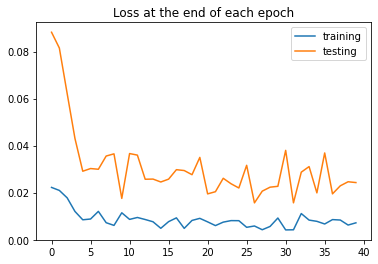

In [200]:
plt.plot([x/(len(train_idx)/100) for x in np.array(train_losses)], label='training')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_losses)], label='testing')
plt.title('Loss at the end of each epoch')
plt.legend()

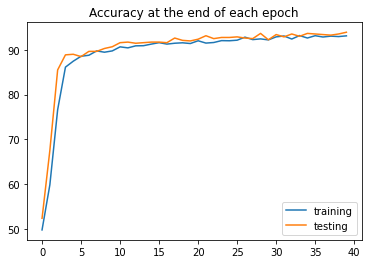

In [201]:
plt.plot([x/(len(train_idx)/100) for x in np.array(train_correct)], label='training')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_correct)], label='testing')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [202]:
torch.save(CNNmodel.state_dict(), 'siec_od_0_lr_00001_ep40.pt')

### Learning rate: 0.00001, epoch no.: 100

In [183]:
criterion = nn.CrossEntropyLoss()
CNNmodel = ConvolutionalNetwork()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.00001)

In [184]:
result = train_model(CNNmodel, criterion, optimizer, 100)

CNNmodel,train_losses, test_losses, train_correct, test_correct = result

Epoka: 0, seria: 1, strata: 0.6936867237091064, dokładność:  51.000%
Epoka: 0, seria: 2, strata: 0.6946291923522949, dokładność:  51.500%
Epoka: 0, seria: 3, strata: 0.6986229419708252, dokładność:  50.000%
Epoka: 0, seria: 4, strata: 0.6947581768035889, dokładność:  50.250%
Epoka: 0, seria: 5, strata: 0.6942839622497559, dokładność:  49.800%
Epoka: 0, seria: 6, strata: 0.7027418613433838, dokładność:  48.667%
Epoka: 0, seria: 7, strata: 0.6957165002822876, dokładność:  48.714%
Epoka: 0, seria: 8, strata: 0.6883128881454468, dokładność:  49.250%
Epoka: 0, seria: 9, strata: 0.6902006268501282, dokładność:  49.778%
Epoka: 0, seria: 10, strata: 0.6964628100395203, dokładność:  49.500%
Epoka: 0, seria: 11, strata: 0.6907418966293335, dokładność:  49.727%
Epoka: 0, seria: 12, strata: 0.6926200985908508, dokładność:  49.750%
Epoka: 0, seria: 13, strata: 0.6918842792510986, dokładność:  49.769%
Epoka: 0, seria: 14, strata: 0.6845111846923828, dokładność:  50.286%
Epoka: 0, seria: 15, strata: 

/home/mat/.local/lib/python3.6/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoka: 0, seria: 21, strata: 0.688080906867981, dokładność:  50.810%
Epoka: 0, seria: 22, strata: 0.6872032880783081, dokładność:  50.864%
Epoka: 0, seria: 23, strata: 0.6910563707351685, dokładność:  50.783%
Epoka: 0, seria: 24, strata: 0.6901304721832275, dokładność:  50.792%
Epoka: 0, seria: 25, strata: 0.6801228523254395, dokładność:  51.040%
Epoka: 0, seria: 26, strata: 0.6901764869689941, dokładność:  51.000%
Epoka: 0, seria: 27, strata: 0.6940352916717529, dokładność:  50.778%
Epoka: 0, seria: 28, strata: 0.6889515519142151, dokładność:  50.821%
Epoka: 0, seria: 29, strata: 0.6804457306861877, dokładność:  51.034%
Epoka: 0, seria: 30, strata: 0.68229079246521, dokładność:  51.100%
Epoka: 0, seria: 31, strata: 0.6794769763946533, dokładność:  51.258%
Epoka: 1, seria: 1, strata: 0.6845044493675232, dokładność:  53.000%
Epoka: 1, seria: 2, strata: 0.6842951774597168, dokładność:  52.500%
Epoka: 1, seria: 3, strata: 0.6736395955085754, dokładność:  56.667%
Epoka: 1, seria: 4, strata

Epoka: 4, seria: 15, strata: 0.30794423818588257, dokładność:  87.667%
Epoka: 4, seria: 16, strata: 0.33611512184143066, dokładność:  87.562%
Epoka: 4, seria: 17, strata: 0.33100971579551697, dokładność:  87.706%
Epoka: 4, seria: 18, strata: 0.2957571744918823, dokładność:  87.944%
Epoka: 4, seria: 19, strata: 0.33511826395988464, dokładność:  87.842%
Epoka: 4, seria: 20, strata: 0.411641389131546, dokładność:  87.500%
Epoka: 4, seria: 21, strata: 0.33547523617744446, dokładność:  87.429%
Epoka: 4, seria: 22, strata: 0.3510764241218567, dokładność:  87.409%
Epoka: 4, seria: 23, strata: 0.32449817657470703, dokładność:  87.348%
Epoka: 4, seria: 24, strata: 0.2981669306755066, dokładność:  87.333%
Epoka: 4, seria: 25, strata: 0.34706905484199524, dokładność:  87.360%
Epoka: 4, seria: 26, strata: 0.3303700387477875, dokładność:  87.308%
Epoka: 4, seria: 27, strata: 0.2831948399543762, dokładność:  87.407%
Epoka: 4, seria: 28, strata: 0.31526902318000793, dokładność:  87.500%
Epoka: 4, ser

Epoka: 8, seria: 8, strata: 0.37527692317962646, dokładność:  87.625%
Epoka: 8, seria: 9, strata: 0.36694473028182983, dokładność:  87.556%
Epoka: 8, seria: 10, strata: 0.27906015515327454, dokładność:  87.700%
Epoka: 8, seria: 11, strata: 0.24879732728004456, dokładność:  88.000%
Epoka: 8, seria: 12, strata: 0.2371164709329605, dokładność:  88.167%
Epoka: 8, seria: 13, strata: 0.32565727829933167, dokładność:  87.846%
Epoka: 8, seria: 14, strata: 0.24732045829296112, dokładność:  87.929%
Epoka: 8, seria: 15, strata: 0.284621000289917, dokładność:  88.133%
Epoka: 8, seria: 16, strata: 0.21386519074440002, dokładność:  88.500%
Epoka: 8, seria: 17, strata: 0.16821710765361786, dokładność:  88.824%
Epoka: 8, seria: 18, strata: 0.2525026798248291, dokładność:  88.833%
Epoka: 8, seria: 19, strata: 0.2755366563796997, dokładność:  89.000%
Epoka: 8, seria: 20, strata: 0.28107497096061707, dokładność:  88.950%
Epoka: 8, seria: 21, strata: 0.2621700167655945, dokładność:  89.048%
Epoka: 8, seri

Epoka: 11, seria: 31, strata: 0.2176896631717682, dokładność:  90.548%
Epoka: 12, seria: 1, strata: 0.2304607629776001, dokładność:  93.000%
Epoka: 12, seria: 2, strata: 0.23306851089000702, dokładność:  91.500%
Epoka: 12, seria: 3, strata: 0.3610619604587555, dokładność:  89.333%
Epoka: 12, seria: 4, strata: 0.3572002649307251, dokładność:  88.500%
Epoka: 12, seria: 5, strata: 0.32719171047210693, dokładność:  87.800%
Epoka: 12, seria: 6, strata: 0.3101053535938263, dokładność:  88.167%
Epoka: 12, seria: 7, strata: 0.19495099782943726, dokładność:  88.857%
Epoka: 12, seria: 8, strata: 0.20164130628108978, dokładność:  89.500%
Epoka: 12, seria: 9, strata: 0.20569592714309692, dokładność:  89.889%
Epoka: 12, seria: 10, strata: 0.23419266939163208, dokładność:  90.000%
Epoka: 12, seria: 11, strata: 0.16308465600013733, dokładność:  90.455%
Epoka: 12, seria: 12, strata: 0.21250440180301666, dokładność:  90.500%
Epoka: 12, seria: 13, strata: 0.23376993834972382, dokładność:  90.385%
Epoka:

Epoka: 15, seria: 22, strata: 0.2699340283870697, dokładność:  91.455%
Epoka: 15, seria: 23, strata: 0.17476870119571686, dokładność:  91.609%
Epoka: 15, seria: 24, strata: 0.30369797348976135, dokładność:  91.417%
Epoka: 15, seria: 25, strata: 0.32009175419807434, dokładność:  91.280%
Epoka: 15, seria: 26, strata: 0.18480026721954346, dokładność:  91.385%
Epoka: 15, seria: 27, strata: 0.2541041672229767, dokładność:  91.259%
Epoka: 15, seria: 28, strata: 0.12544576823711395, dokładność:  91.429%
Epoka: 15, seria: 29, strata: 0.1921420842409134, dokładność:  91.414%
Epoka: 15, seria: 30, strata: 0.3234878182411194, dokładność:  91.300%
Epoka: 15, seria: 31, strata: 0.25637245178222656, dokładność:  91.065%
Epoka: 16, seria: 1, strata: 0.3344515264034271, dokładność:  87.000%
Epoka: 16, seria: 2, strata: 0.17205095291137695, dokładność:  91.000%
Epoka: 16, seria: 3, strata: 0.24302087724208832, dokładność:  89.667%
Epoka: 16, seria: 4, strata: 0.2685181498527527, dokładność:  90.000%
Ep

Epoka: 19, seria: 13, strata: 0.1439586579799652, dokładność:  91.462%
Epoka: 19, seria: 14, strata: 0.1919209510087967, dokładność:  91.571%
Epoka: 19, seria: 15, strata: 0.1319631189107895, dokładność:  91.933%
Epoka: 19, seria: 16, strata: 0.17959871888160706, dokładność:  92.000%
Epoka: 19, seria: 17, strata: 0.27139177918434143, dokładność:  91.882%
Epoka: 19, seria: 18, strata: 0.22555403411388397, dokładność:  92.000%
Epoka: 19, seria: 19, strata: 0.18446531891822815, dokładność:  92.105%
Epoka: 19, seria: 20, strata: 0.19482679665088654, dokładność:  92.100%
Epoka: 19, seria: 21, strata: 0.2854585647583008, dokładność:  92.048%
Epoka: 19, seria: 22, strata: 0.1784934252500534, dokładność:  92.000%
Epoka: 19, seria: 23, strata: 0.1647317260503769, dokładność:  91.957%
Epoka: 19, seria: 24, strata: 0.17881149053573608, dokładność:  92.000%
Epoka: 19, seria: 25, strata: 0.24543967843055725, dokładność:  91.920%
Epoka: 19, seria: 26, strata: 0.19690518081188202, dokładność:  92.000

Epoka: 23, seria: 4, strata: 0.29094401001930237, dokładność:  91.500%
Epoka: 23, seria: 5, strata: 0.2683088183403015, dokładność:  91.000%
Epoka: 23, seria: 6, strata: 0.25511372089385986, dokładność:  90.667%
Epoka: 23, seria: 7, strata: 0.1772516816854477, dokładność:  91.000%
Epoka: 23, seria: 8, strata: 0.14549803733825684, dokładność:  91.500%
Epoka: 23, seria: 9, strata: 0.12374231219291687, dokładność:  92.000%
Epoka: 23, seria: 10, strata: 0.13473689556121826, dokładność:  92.400%
Epoka: 23, seria: 11, strata: 0.2425166517496109, dokładność:  92.182%
Epoka: 23, seria: 12, strata: 0.22972840070724487, dokładność:  92.167%
Epoka: 23, seria: 13, strata: 0.17134524881839752, dokładność:  92.154%
Epoka: 23, seria: 14, strata: 0.26450642943382263, dokładność:  92.071%
Epoka: 23, seria: 15, strata: 0.23227518796920776, dokładność:  92.000%
Epoka: 23, seria: 16, strata: 0.17909856140613556, dokładność:  92.062%
Epoka: 23, seria: 17, strata: 0.17223189771175385, dokładność:  92.118%
E

Epoka: 26, seria: 26, strata: 0.09755922108888626, dokładność:  92.731%
Epoka: 26, seria: 27, strata: 0.21098379790782928, dokładność:  92.741%
Epoka: 26, seria: 28, strata: 0.16802045702934265, dokładność:  92.857%
Epoka: 26, seria: 29, strata: 0.13231927156448364, dokładność:  92.897%
Epoka: 26, seria: 30, strata: 0.28261110186576843, dokładność:  92.833%
Epoka: 26, seria: 31, strata: 0.21468907594680786, dokładność:  92.613%
Epoka: 27, seria: 1, strata: 0.26045191287994385, dokładność:  92.000%
Epoka: 27, seria: 2, strata: 0.1821524202823639, dokładność:  92.000%
Epoka: 27, seria: 3, strata: 0.21187275648117065, dokładność:  92.333%
Epoka: 27, seria: 4, strata: 0.1398637890815735, dokładność:  93.250%
Epoka: 27, seria: 5, strata: 0.20643655955791473, dokładność:  93.000%
Epoka: 27, seria: 6, strata: 0.15640473365783691, dokładność:  93.000%
Epoka: 27, seria: 7, strata: 0.22517409920692444, dokładność:  92.714%
Epoka: 27, seria: 8, strata: 0.18452481925487518, dokładność:  92.375%
Ep

Epoka: 30, seria: 17, strata: 0.2021007388830185, dokładność:  93.471%
Epoka: 30, seria: 18, strata: 0.1370222270488739, dokładność:  93.667%
Epoka: 30, seria: 19, strata: 0.20053483545780182, dokładność:  93.579%
Epoka: 30, seria: 20, strata: 0.1985149383544922, dokładność:  93.550%
Epoka: 30, seria: 21, strata: 0.23614536225795746, dokładność:  93.429%
Epoka: 30, seria: 22, strata: 0.17688395082950592, dokładność:  93.364%
Epoka: 30, seria: 23, strata: 0.21596147119998932, dokładność:  93.217%
Epoka: 30, seria: 24, strata: 0.22751112282276154, dokładność:  93.125%
Epoka: 30, seria: 25, strata: 0.25904229283332825, dokładność:  93.040%
Epoka: 30, seria: 26, strata: 0.2237936556339264, dokładność:  93.038%
Epoka: 30, seria: 27, strata: 0.2044816017150879, dokładność:  93.037%
Epoka: 30, seria: 28, strata: 0.1828775405883789, dokładność:  93.071%
Epoka: 30, seria: 29, strata: 0.08465324342250824, dokładność:  93.241%
Epoka: 30, seria: 30, strata: 0.1546601504087448, dokładność:  93.200%

Epoka: 34, seria: 8, strata: 0.20189999043941498, dokładność:  93.500%
Epoka: 34, seria: 9, strata: 0.25817152857780457, dokładność:  93.333%
Epoka: 34, seria: 10, strata: 0.19521687924861908, dokładność:  93.600%
Epoka: 34, seria: 11, strata: 0.20830275118350983, dokładność:  93.545%
Epoka: 34, seria: 12, strata: 0.1754016876220703, dokładność:  93.667%
Epoka: 34, seria: 13, strata: 0.10333142429590225, dokładność:  93.923%
Epoka: 34, seria: 14, strata: 0.17104563117027283, dokładność:  94.000%
Epoka: 34, seria: 15, strata: 0.20811371505260468, dokładność:  93.867%
Epoka: 34, seria: 16, strata: 0.09964758902788162, dokładność:  94.125%
Epoka: 34, seria: 17, strata: 0.2280651330947876, dokładność:  93.882%
Epoka: 34, seria: 18, strata: 0.13297824561595917, dokładność:  94.000%
Epoka: 34, seria: 19, strata: 0.18015794456005096, dokładność:  94.053%
Epoka: 34, seria: 20, strata: 0.18374724686145782, dokładność:  94.100%
Epoka: 34, seria: 21, strata: 0.13783273100852966, dokładność:  94.1

Epoka: 37, seria: 30, strata: 0.11440545320510864, dokładność:  93.367%
Epoka: 37, seria: 31, strata: 0.20892195403575897, dokładność:  93.161%
Epoka: 38, seria: 1, strata: 0.17453846335411072, dokładność:  94.000%
Epoka: 38, seria: 2, strata: 0.17584358155727386, dokładność:  93.500%
Epoka: 38, seria: 3, strata: 0.14057999849319458, dokładność:  94.000%
Epoka: 38, seria: 4, strata: 0.1750205010175705, dokładność:  93.500%
Epoka: 38, seria: 5, strata: 0.12663550674915314, dokładność:  94.200%
Epoka: 38, seria: 6, strata: 0.11908676475286484, dokładność:  94.333%
Epoka: 38, seria: 7, strata: 0.13866020739078522, dokładność:  94.429%
Epoka: 38, seria: 8, strata: 0.1346576064825058, dokładność:  94.750%
Epoka: 38, seria: 9, strata: 0.1732451468706131, dokładność:  94.556%
Epoka: 38, seria: 10, strata: 0.16264604032039642, dokładność:  94.400%
Epoka: 38, seria: 11, strata: 0.30010730028152466, dokładność:  93.727%
Epoka: 38, seria: 12, strata: 0.2063789814710617, dokładność:  93.750%
Epoka

Epoka: 41, seria: 21, strata: 0.13360339403152466, dokładność:  93.571%
Epoka: 41, seria: 22, strata: 0.2020721584558487, dokładność:  93.455%
Epoka: 41, seria: 23, strata: 0.10637074708938599, dokładność:  93.522%
Epoka: 41, seria: 24, strata: 0.21589338779449463, dokładność:  93.458%
Epoka: 41, seria: 25, strata: 0.16799823939800262, dokładność:  93.480%
Epoka: 41, seria: 26, strata: 0.1366296261548996, dokładność:  93.500%
Epoka: 41, seria: 27, strata: 0.15593717992305756, dokładność:  93.519%
Epoka: 41, seria: 28, strata: 0.13698025047779083, dokładność:  93.607%
Epoka: 41, seria: 29, strata: 0.11248573660850525, dokładność:  93.759%
Epoka: 41, seria: 30, strata: 0.12390084564685822, dokładność:  93.767%
Epoka: 41, seria: 31, strata: 0.1855960637331009, dokładność:  93.613%
Epoka: 42, seria: 1, strata: 0.13700971007347107, dokładność:  96.000%
Epoka: 42, seria: 2, strata: 0.17050468921661377, dokładność:  95.000%
Epoka: 42, seria: 3, strata: 0.12417575716972351, dokładność:  95.333

Epoka: 45, seria: 12, strata: 0.1209854856133461, dokładność:  94.083%
Epoka: 45, seria: 13, strata: 0.18314588069915771, dokładność:  94.154%
Epoka: 45, seria: 14, strata: 0.15967130661010742, dokładność:  94.143%
Epoka: 45, seria: 15, strata: 0.07509744167327881, dokładność:  94.400%
Epoka: 45, seria: 16, strata: 0.22377729415893555, dokładność:  94.188%
Epoka: 45, seria: 17, strata: 0.18513166904449463, dokładność:  94.118%
Epoka: 45, seria: 18, strata: 0.19198885560035706, dokładność:  94.111%
Epoka: 45, seria: 19, strata: 0.1995084434747696, dokładność:  93.947%
Epoka: 45, seria: 20, strata: 0.19156673550605774, dokładność:  93.900%
Epoka: 45, seria: 21, strata: 0.19830411672592163, dokładność:  93.762%
Epoka: 45, seria: 22, strata: 0.13535402715206146, dokładność:  93.955%
Epoka: 45, seria: 23, strata: 0.16181312501430511, dokładność:  94.000%
Epoka: 45, seria: 24, strata: 0.2600093483924866, dokładność:  93.958%
Epoka: 45, seria: 25, strata: 0.12789662182331085, dokładność:  94.

Epoka: 49, seria: 3, strata: 0.14892122149467468, dokładność:  93.667%
Epoka: 49, seria: 4, strata: 0.1841103583574295, dokładność:  94.250%
Epoka: 49, seria: 5, strata: 0.19618329405784607, dokładność:  93.800%
Epoka: 49, seria: 6, strata: 0.2097010761499405, dokładność:  93.167%
Epoka: 49, seria: 7, strata: 0.17480997741222382, dokładność:  93.143%
Epoka: 49, seria: 8, strata: 0.10822850465774536, dokładność:  93.500%
Epoka: 49, seria: 9, strata: 0.26216965913772583, dokładność:  93.222%
Epoka: 49, seria: 10, strata: 0.1001109778881073, dokładność:  93.600%
Epoka: 49, seria: 11, strata: 0.2039089947938919, dokładność:  93.364%
Epoka: 49, seria: 12, strata: 0.1476334184408188, dokładność:  93.500%
Epoka: 49, seria: 13, strata: 0.17964065074920654, dokładność:  93.538%
Epoka: 49, seria: 14, strata: 0.17983408272266388, dokładność:  93.429%
Epoka: 49, seria: 15, strata: 0.1549980342388153, dokładność:  93.533%
Epoka: 49, seria: 16, strata: 0.08366745710372925, dokładność:  93.750%
Epoka

Epoka: 52, seria: 25, strata: 0.11884767562150955, dokładność:  94.440%
Epoka: 52, seria: 26, strata: 0.09047658741474152, dokładność:  94.538%
Epoka: 52, seria: 27, strata: 0.13756170868873596, dokładność:  94.481%
Epoka: 52, seria: 28, strata: 0.20327308773994446, dokładność:  94.429%
Epoka: 52, seria: 29, strata: 0.2095492035150528, dokładność:  94.276%
Epoka: 52, seria: 30, strata: 0.23887521028518677, dokładność:  94.233%
Epoka: 52, seria: 31, strata: 0.13121189177036285, dokładność:  94.097%
Epoka: 53, seria: 1, strata: 0.16574139893054962, dokładność:  93.000%
Epoka: 53, seria: 2, strata: 0.2046549916267395, dokładność:  93.000%
Epoka: 53, seria: 3, strata: 0.15022307634353638, dokładność:  93.333%
Epoka: 53, seria: 4, strata: 0.19774873554706573, dokładność:  93.000%
Epoka: 53, seria: 5, strata: 0.15743237733840942, dokładność:  93.200%
Epoka: 53, seria: 6, strata: 0.1621461808681488, dokładność:  93.333%
Epoka: 53, seria: 7, strata: 0.136460080742836, dokładność:  93.714%
Epok

Epoka: 56, seria: 16, strata: 0.22419443726539612, dokładność:  94.312%
Epoka: 56, seria: 17, strata: 0.21406835317611694, dokładność:  94.118%
Epoka: 56, seria: 18, strata: 0.1414918452501297, dokładność:  94.167%
Epoka: 56, seria: 19, strata: 0.1174100786447525, dokładność:  94.211%
Epoka: 56, seria: 20, strata: 0.17282207310199738, dokładność:  94.250%
Epoka: 56, seria: 21, strata: 0.1719801276922226, dokładność:  94.143%
Epoka: 56, seria: 22, strata: 0.3669201135635376, dokładność:  93.955%
Epoka: 56, seria: 23, strata: 0.13924559950828552, dokładność:  93.957%
Epoka: 56, seria: 24, strata: 0.15999345481395721, dokładność:  94.000%
Epoka: 56, seria: 25, strata: 0.18020087480545044, dokładność:  94.000%
Epoka: 56, seria: 26, strata: 0.1104128286242485, dokładność:  94.115%
Epoka: 56, seria: 27, strata: 0.11250840127468109, dokładność:  94.222%
Epoka: 56, seria: 28, strata: 0.1182936280965805, dokładność:  94.286%
Epoka: 56, seria: 29, strata: 0.1836441457271576, dokładność:  94.207%

Epoka: 60, seria: 7, strata: 0.14363236725330353, dokładność:  94.286%
Epoka: 60, seria: 8, strata: 0.08667734265327454, dokładność:  94.375%
Epoka: 60, seria: 9, strata: 0.11202148348093033, dokładność:  94.667%
Epoka: 60, seria: 10, strata: 0.1814623773097992, dokładność:  94.400%
Epoka: 60, seria: 11, strata: 0.14380045235157013, dokładność:  94.455%
Epoka: 60, seria: 12, strata: 0.1767130047082901, dokładność:  94.250%
Epoka: 60, seria: 13, strata: 0.13070443272590637, dokładność:  94.462%
Epoka: 60, seria: 14, strata: 0.15006546676158905, dokładność:  94.429%
Epoka: 60, seria: 15, strata: 0.20469816029071808, dokładność:  94.333%
Epoka: 60, seria: 16, strata: 0.16508334875106812, dokładność:  94.188%
Epoka: 60, seria: 17, strata: 0.17057734727859497, dokładność:  94.176%
Epoka: 60, seria: 18, strata: 0.11136980354785919, dokładność:  94.222%
Epoka: 60, seria: 19, strata: 0.25409996509552, dokładność:  94.105%
Epoka: 60, seria: 20, strata: 0.16643808782100677, dokładność:  94.050%


Epoka: 63, seria: 29, strata: 0.1929134726524353, dokładność:  94.276%
Epoka: 63, seria: 30, strata: 0.1339142769575119, dokładność:  94.267%
Epoka: 63, seria: 31, strata: 0.11838032305240631, dokładność:  94.161%
Epoka: 64, seria: 1, strata: 0.16597296297550201, dokładność:  95.000%
Epoka: 64, seria: 2, strata: 0.14499565958976746, dokładność:  95.500%
Epoka: 64, seria: 3, strata: 0.09308433532714844, dokładność:  95.667%
Epoka: 64, seria: 4, strata: 0.08373233675956726, dokładność:  96.500%
Epoka: 64, seria: 5, strata: 0.14907589554786682, dokładność:  96.000%
Epoka: 64, seria: 6, strata: 0.15559343993663788, dokładność:  95.500%
Epoka: 64, seria: 7, strata: 0.17536552250385284, dokładność:  95.000%
Epoka: 64, seria: 8, strata: 0.18592886626720428, dokładność:  94.625%
Epoka: 64, seria: 9, strata: 0.19857023656368256, dokładność:  94.222%
Epoka: 64, seria: 10, strata: 0.1320379376411438, dokładność:  94.400%
Epoka: 64, seria: 11, strata: 0.074887715280056, dokładność:  94.909%
Epoka:

Epoka: 67, seria: 20, strata: 0.0965098962187767, dokładność:  94.700%
Epoka: 67, seria: 21, strata: 0.06491149216890335, dokładność:  94.905%
Epoka: 67, seria: 22, strata: 0.10318396240472794, dokładność:  95.000%
Epoka: 67, seria: 23, strata: 0.14313657581806183, dokładność:  94.957%
Epoka: 67, seria: 24, strata: 0.2176916003227234, dokładność:  94.750%
Epoka: 67, seria: 25, strata: 0.27003827691078186, dokładność:  94.640%
Epoka: 67, seria: 26, strata: 0.14520305395126343, dokładność:  94.538%
Epoka: 67, seria: 27, strata: 0.1375870257616043, dokładność:  94.556%
Epoka: 67, seria: 28, strata: 0.11047214269638062, dokładność:  94.571%
Epoka: 67, seria: 29, strata: 0.1640307754278183, dokładność:  94.621%
Epoka: 67, seria: 30, strata: 0.15818220376968384, dokładność:  94.567%
Epoka: 67, seria: 31, strata: 0.0677088052034378, dokładność:  94.516%
Epoka: 68, seria: 1, strata: 0.1724529266357422, dokładność:  94.000%
Epoka: 68, seria: 2, strata: 0.14423759281635284, dokładność:  94.500%


Epoka: 71, seria: 11, strata: 0.09746058285236359, dokładność:  94.818%
Epoka: 71, seria: 12, strata: 0.08067755401134491, dokładność:  94.917%
Epoka: 71, seria: 13, strata: 0.18007157742977142, dokładność:  94.846%
Epoka: 71, seria: 14, strata: 0.1991390734910965, dokładność:  94.643%
Epoka: 71, seria: 15, strata: 0.09829576313495636, dokładność:  94.733%
Epoka: 71, seria: 16, strata: 0.1698928326368332, dokładność:  94.375%
Epoka: 71, seria: 17, strata: 0.17487506568431854, dokładność:  94.294%
Epoka: 71, seria: 18, strata: 0.10601751506328583, dokładność:  94.500%
Epoka: 71, seria: 19, strata: 0.13475827872753143, dokładność:  94.368%
Epoka: 71, seria: 20, strata: 0.07475075870752335, dokładność:  94.550%
Epoka: 71, seria: 21, strata: 0.12977053225040436, dokładność:  94.524%
Epoka: 71, seria: 22, strata: 0.170035719871521, dokładność:  94.455%
Epoka: 71, seria: 23, strata: 0.17187008261680603, dokładność:  94.435%
Epoka: 71, seria: 24, strata: 0.1274101585149765, dokładność:  94.45

Epoka: 75, seria: 2, strata: 0.1948058158159256, dokładność:  94.500%
Epoka: 75, seria: 3, strata: 0.1419239044189453, dokładność:  95.000%
Epoka: 75, seria: 4, strata: 0.12003839761018753, dokładność:  95.500%
Epoka: 75, seria: 5, strata: 0.16919265687465668, dokładność:  94.200%
Epoka: 75, seria: 6, strata: 0.09634573012590408, dokładność:  94.500%
Epoka: 75, seria: 7, strata: 0.13021813333034515, dokładność:  94.429%
Epoka: 75, seria: 8, strata: 0.1148526668548584, dokładność:  94.500%
Epoka: 75, seria: 9, strata: 0.12745195627212524, dokładność:  94.556%
Epoka: 75, seria: 10, strata: 0.0842931941151619, dokładność:  94.700%
Epoka: 75, seria: 11, strata: 0.17729611694812775, dokładność:  94.727%
Epoka: 75, seria: 12, strata: 0.19080224633216858, dokładność:  94.833%
Epoka: 75, seria: 13, strata: 0.1710590124130249, dokładność:  94.769%
Epoka: 75, seria: 14, strata: 0.12497857213020325, dokładność:  94.714%
Epoka: 75, seria: 15, strata: 0.14334207773208618, dokładność:  94.600%
Epoka

Epoka: 78, seria: 24, strata: 0.17317643761634827, dokładność:  94.833%
Epoka: 78, seria: 25, strata: 0.14355383813381195, dokładność:  94.760%
Epoka: 78, seria: 26, strata: 0.1462511420249939, dokładność:  94.692%
Epoka: 78, seria: 27, strata: 0.0914815366268158, dokładność:  94.815%
Epoka: 78, seria: 28, strata: 0.09821008890867233, dokładność:  94.929%
Epoka: 78, seria: 29, strata: 0.12125067412853241, dokładność:  94.931%
Epoka: 78, seria: 30, strata: 0.16453924775123596, dokładność:  95.000%
Epoka: 78, seria: 31, strata: 0.11838122457265854, dokładność:  94.839%
Epoka: 79, seria: 1, strata: 0.14527469873428345, dokładność:  94.000%
Epoka: 79, seria: 2, strata: 0.1425732970237732, dokładność:  95.000%
Epoka: 79, seria: 3, strata: 0.16798780858516693, dokładność:  95.333%
Epoka: 79, seria: 4, strata: 0.14430774748325348, dokładność:  95.250%
Epoka: 79, seria: 5, strata: 0.14645400643348694, dokładność:  95.400%
Epoka: 79, seria: 6, strata: 0.16585248708724976, dokładność:  95.333%
E

Epoka: 82, seria: 15, strata: 0.0982644259929657, dokładność:  95.533%
Epoka: 82, seria: 16, strata: 0.13599759340286255, dokładność:  95.625%
Epoka: 82, seria: 17, strata: 0.1282794028520584, dokładność:  95.647%
Epoka: 82, seria: 18, strata: 0.18090711534023285, dokładność:  95.444%
Epoka: 82, seria: 19, strata: 0.19441837072372437, dokładność:  95.368%
Epoka: 82, seria: 20, strata: 0.16404347121715546, dokładność:  95.300%
Epoka: 82, seria: 21, strata: 0.14011892676353455, dokładność:  95.238%
Epoka: 82, seria: 22, strata: 0.1536484807729721, dokładność:  95.136%
Epoka: 82, seria: 23, strata: 0.13865093886852264, dokładność:  95.130%
Epoka: 82, seria: 24, strata: 0.06360534578561783, dokładność:  95.292%
Epoka: 82, seria: 25, strata: 0.1254175305366516, dokładność:  95.240%
Epoka: 82, seria: 26, strata: 0.11079545319080353, dokładność:  95.192%
Epoka: 82, seria: 27, strata: 0.08697124570608139, dokładność:  95.259%
Epoka: 82, seria: 28, strata: 0.10208318382501602, dokładność:  95.3

Epoka: 86, seria: 6, strata: 0.17149105668067932, dokładność:  95.333%
Epoka: 86, seria: 7, strata: 0.13060206174850464, dokładność:  95.429%
Epoka: 86, seria: 8, strata: 0.1528628021478653, dokładność:  95.625%
Epoka: 86, seria: 9, strata: 0.08923237025737762, dokładność:  95.778%
Epoka: 86, seria: 10, strata: 0.18707947432994843, dokładność:  95.500%
Epoka: 86, seria: 11, strata: 0.17838498950004578, dokładność:  95.273%
Epoka: 86, seria: 12, strata: 0.12430273741483688, dokładność:  95.333%
Epoka: 86, seria: 13, strata: 0.10245392471551895, dokładność:  95.462%
Epoka: 86, seria: 14, strata: 0.20546722412109375, dokładność:  95.357%
Epoka: 86, seria: 15, strata: 0.1494383066892624, dokładność:  95.267%
Epoka: 86, seria: 16, strata: 0.09591226279735565, dokładność:  95.375%
Epoka: 86, seria: 17, strata: 0.11255237460136414, dokładność:  95.412%
Epoka: 86, seria: 18, strata: 0.12156037241220474, dokładność:  95.500%
Epoka: 86, seria: 19, strata: 0.19019588828086853, dokładność:  95.421

Epoka: 89, seria: 28, strata: 0.12525953352451324, dokładność:  95.964%
Epoka: 89, seria: 29, strata: 0.30286112427711487, dokładność:  95.621%
Epoka: 89, seria: 30, strata: 0.13832460343837738, dokładność:  95.600%
Epoka: 89, seria: 31, strata: 0.1017172783613205, dokładność:  95.484%
Epoka: 90, seria: 1, strata: 0.08550050854682922, dokładność:  97.000%
Epoka: 90, seria: 2, strata: 0.23202629387378693, dokładność:  95.000%
Epoka: 90, seria: 3, strata: 0.15070845186710358, dokładność:  95.667%
Epoka: 90, seria: 4, strata: 0.12435794621706009, dokładność:  95.750%
Epoka: 90, seria: 5, strata: 0.12240558862686157, dokładność:  95.600%
Epoka: 90, seria: 6, strata: 0.06694069504737854, dokładność:  96.000%
Epoka: 90, seria: 7, strata: 0.2500486671924591, dokładność:  95.286%
Epoka: 90, seria: 8, strata: 0.05469425767660141, dokładność:  95.750%
Epoka: 90, seria: 9, strata: 0.11815138161182404, dokładność:  95.778%
Epoka: 90, seria: 10, strata: 0.17461518943309784, dokładność:  95.300%
Epo

Epoka: 93, seria: 19, strata: 0.1246693879365921, dokładność:  95.316%
Epoka: 93, seria: 20, strata: 0.13518863916397095, dokładność:  95.250%
Epoka: 93, seria: 21, strata: 0.14211207628250122, dokładność:  95.190%
Epoka: 93, seria: 22, strata: 0.10582064837217331, dokładność:  95.182%
Epoka: 93, seria: 23, strata: 0.0873115286231041, dokładność:  95.304%
Epoka: 93, seria: 24, strata: 0.14607958495616913, dokładność:  95.333%
Epoka: 93, seria: 25, strata: 0.114566370844841, dokładność:  95.400%
Epoka: 93, seria: 26, strata: 0.1280391812324524, dokładność:  95.462%
Epoka: 93, seria: 27, strata: 0.1377933919429779, dokładność:  95.481%
Epoka: 93, seria: 28, strata: 0.0797514095902443, dokładność:  95.571%
Epoka: 93, seria: 29, strata: 0.17249611020088196, dokładność:  95.517%
Epoka: 93, seria: 30, strata: 0.1204845979809761, dokładność:  95.467%
Epoka: 93, seria: 31, strata: 0.09547281265258789, dokładność:  95.323%
Epoka: 94, seria: 1, strata: 0.10101604461669922, dokładność:  96.000%
E

Epoka: 97, seria: 10, strata: 0.08919034153223038, dokładność:  95.100%
Epoka: 97, seria: 11, strata: 0.14445091784000397, dokładność:  95.091%
Epoka: 97, seria: 12, strata: 0.17710763216018677, dokładność:  94.833%
Epoka: 97, seria: 13, strata: 0.11246982216835022, dokładność:  95.000%
Epoka: 97, seria: 14, strata: 0.1572885513305664, dokładność:  94.929%
Epoka: 97, seria: 15, strata: 0.08784756064414978, dokładność:  95.000%
Epoka: 97, seria: 16, strata: 0.14865417778491974, dokładność:  94.875%
Epoka: 97, seria: 17, strata: 0.1974523514509201, dokładność:  94.706%
Epoka: 97, seria: 18, strata: 0.1820872724056244, dokładność:  94.667%
Epoka: 97, seria: 19, strata: 0.21367675065994263, dokładność:  94.632%
Epoka: 97, seria: 20, strata: 0.13878387212753296, dokładność:  94.750%
Epoka: 97, seria: 21, strata: 0.08696252107620239, dokładność:  94.762%
Epoka: 97, seria: 22, strata: 0.09848598390817642, dokładność:  94.909%
Epoka: 97, seria: 23, strata: 0.08509772270917892, dokładność:  95.

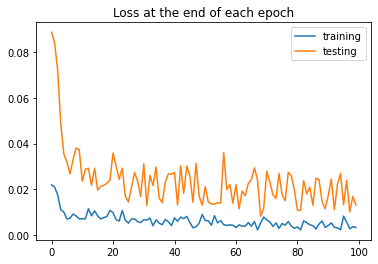

In [185]:
plt.plot([x/(len(train_idx)/100) for x in np.array(train_losses)], label='training')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_losses)], label='testing')
plt.title('Loss at the end of each epoch')
plt.legend()

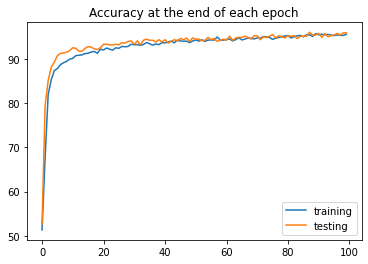

In [186]:
plt.plot([x/(len(train_idx)/100) for x in np.array(train_correct)], label='training')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_correct)], label='testing')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [187]:
torch.save(CNNmodel.state_dict(), 'siec_od_0_95%_lr_00001_ep100.pt')

# Testing on single images

In [203]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load('siec_od_0_95%_lr_00001_ep40.pt'))

<All keys matched successfully>

In [216]:
from PIL import Image, ImageDraw, ImageFont

In [219]:
def predict(image_path):
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image).unsqueeze(0) #adding the "batch dimension"
    
    with torch.no_grad():
        output = model(image)
    
    pos = output[0].argmax()
    image = inv_normalize(image.squeeze(0))
    image = np.transpose(image.numpy(), (1, 2, 0))
    image = Image.fromarray((image*255).astype(np.uint8))
    font = ImageFont.truetype('./font.ttf', 18)
    d = ImageDraw.Draw(image)
    d.text((100,200), class_names[pos], fill="#06F516", font=font)
    plt.imshow(image)

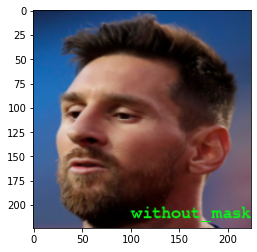

In [220]:
predict('./test_new_data/Untitled.png')

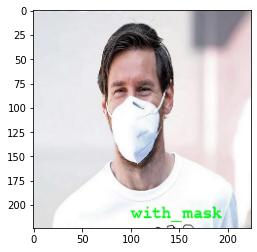

In [221]:
predict('./test_new_data/messi_mask.jpg')

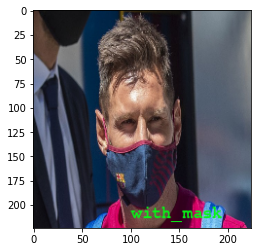

In [222]:
predict('./test_new_data/Messi_with_mask.jpg')

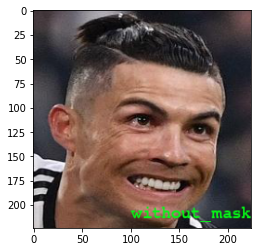

In [223]:
predict('./test_new_data/Ronaldo_without_mask_face.jpg')

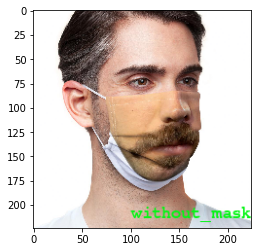

In [224]:
predict('./test_new_data/mustache_mask.jpg')

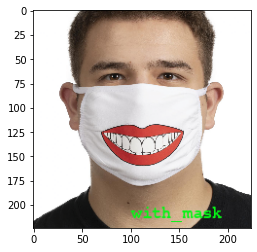

In [225]:
predict('./test_new_data/funny-perfect-smile-printed-mask-34.jpg')